In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

# clean data of listings table
listings['price'] = listings['price'].str.replace('$', '', regex=False)
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].astype('float')

# get rid of alienation
listings.drop(listings[listings['accommodates'] == 0].index, inplace=True) # delete rows where accommodates = 0


# clean calendar table
calendar['price'] = calendar['price'].str.replace('$', '', regex=False)
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].astype('float')

calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '', regex=False)
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '')
calendar['adjusted_price'] = calendar['adjusted_price'].astype('float')

calendar['date'] = pd.to_datetime(calendar['date'])

calendar.loc[calendar['available'] == 't', 'available'] = 1
calendar.loc[calendar['available'] == 'f', 'available'] = 0
calendar['available'] = pd.to_numeric(calendar['available'])


# decide number of accomodates into 4 groups
listings.loc[listings['accommodates'] == 1, 'accommodates_group'] = '1'
listings.loc[listings['accommodates'] == 2, 'accommodates_group'] = '2'
listings.loc[(listings['accommodates'] >= 3) & (listings['accommodates'] <= 6), 'accommodates_group'] = '3 - 6'
listings.loc[listings['accommodates'] >= 7, 'accommodates_group'] = '> 6'

listing_type = listings[['id', 'bedrooms', 'beds', 'accommodates_group']].set_index('id')

In [2]:
# define function to find outliers
def find_outliers_IQR(ser:pd.Series, return_filter=False):
   """Take in a seri and return a seri of outliers via IQR method \n
   If return_filter=True -> return a seri of booleans
   """
   q1=ser.quantile(0.25)
   q3=ser.quantile(0.75)
   IQR=q3-q1

   filterer = ((ser<(q1-1.5*IQR)) | (ser>(q3+1.5*IQR)))
   outliers = ser[filterer]

   if return_filter:
      return filterer
   else: return outliers

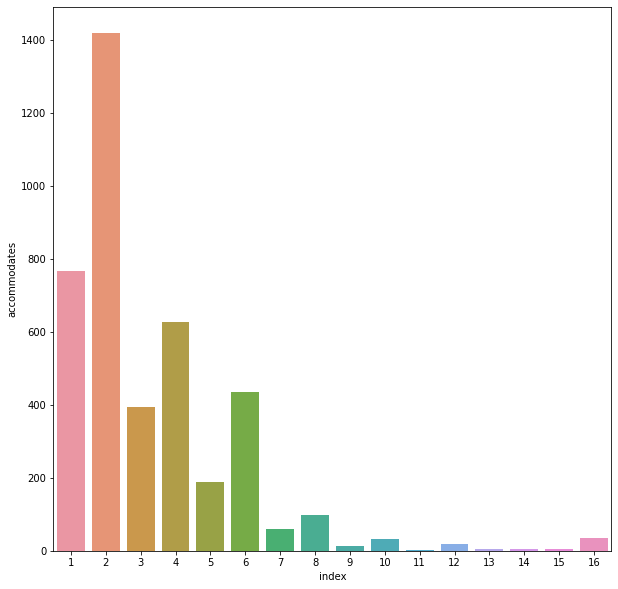

In [3]:
# grouping the number of accommodates
accomodate_no = listings['accommodates'].value_counts()
accomodate_no = accomodate_no.reset_index()

plt.figure(figsize=[10,10])
sns.barplot(data=accomodate_no, x='index', y='accommodates')
plt.show()

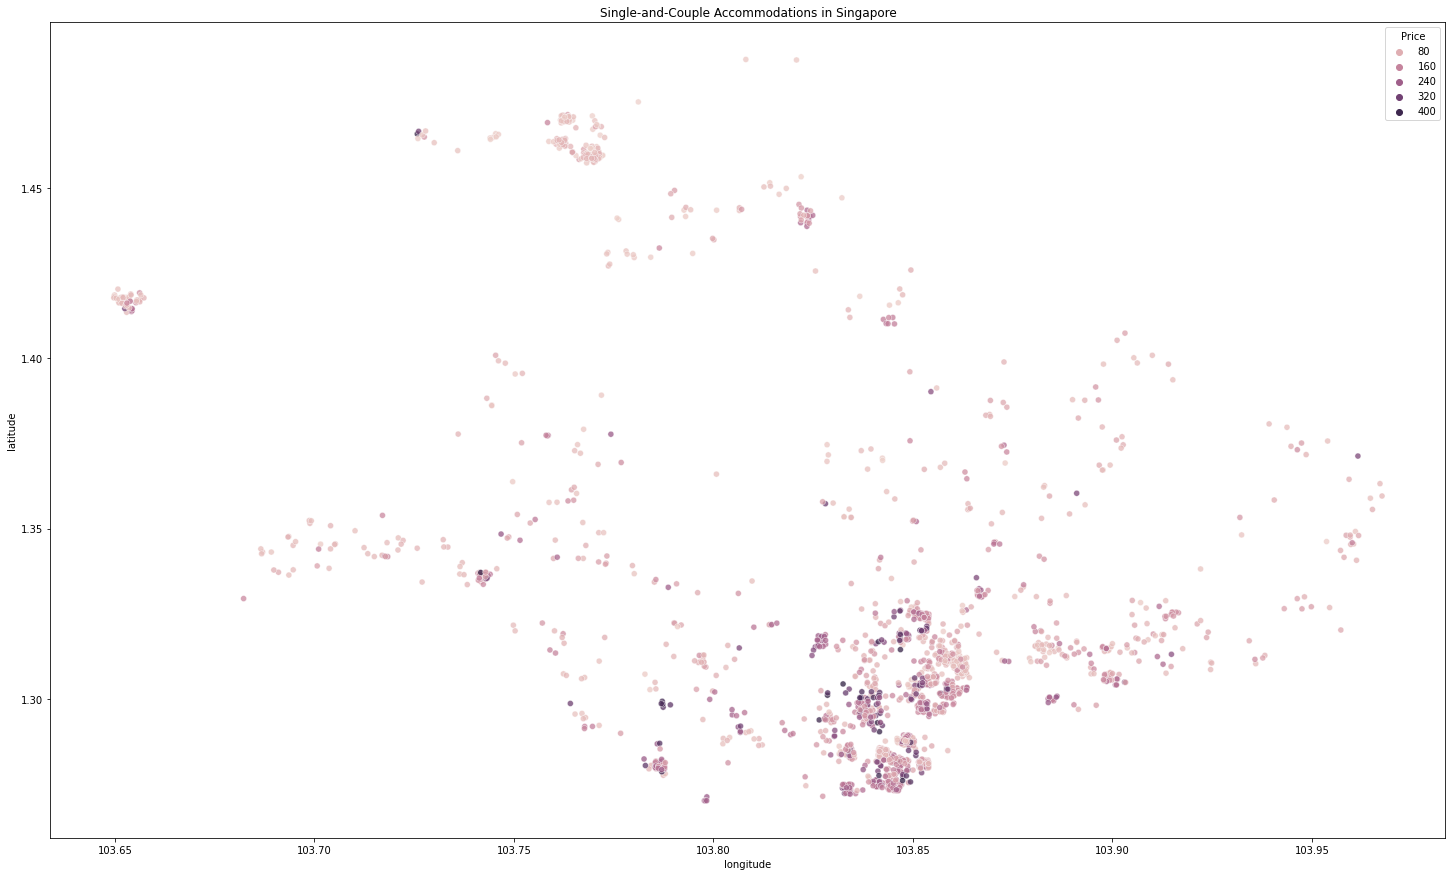

In [4]:
visual_AVG_price = calendar.groupby(['listing_id']).mean()['adjusted_price'].reset_index().set_index('listing_id')
tmp = listings[['id', 'latitude', 'longitude', 'accommodates_group']]
tmp = tmp[tmp['accommodates_group'].isin(['1', '2'])].set_index('id')
visual_AVG_price = visual_AVG_price.join(tmp)
# remove outliers
visual_AVG_price = visual_AVG_price[~find_outliers_IQR(visual_AVG_price['adjusted_price'], return_filter=True)]
visual_AVG_price.dropna(inplace=True)
visual_AVG_price.rename(columns={'adjusted_price':'Price'}, inplace=True)

plt.figure(figsize=(25, 15))
sns.scatterplot(data=visual_AVG_price, y='latitude', x='longitude', hue='Price', alpha=0.75)
plt.title('Single-and-Couple Accommodations in Singapore')
plt.show()

In [5]:
import gmplot
latitude_list = visual_AVG_price['latitude']
longitude_list = visual_AVG_price['longitude']

gmap3 = gmplot.GoogleMapPlotter(1.3545154,103.8254769,12.5)

gmap3.scatter( latitude_list, longitude_list, '#ffc800', size = 40, marker = False )

gmap3.draw('test.html')

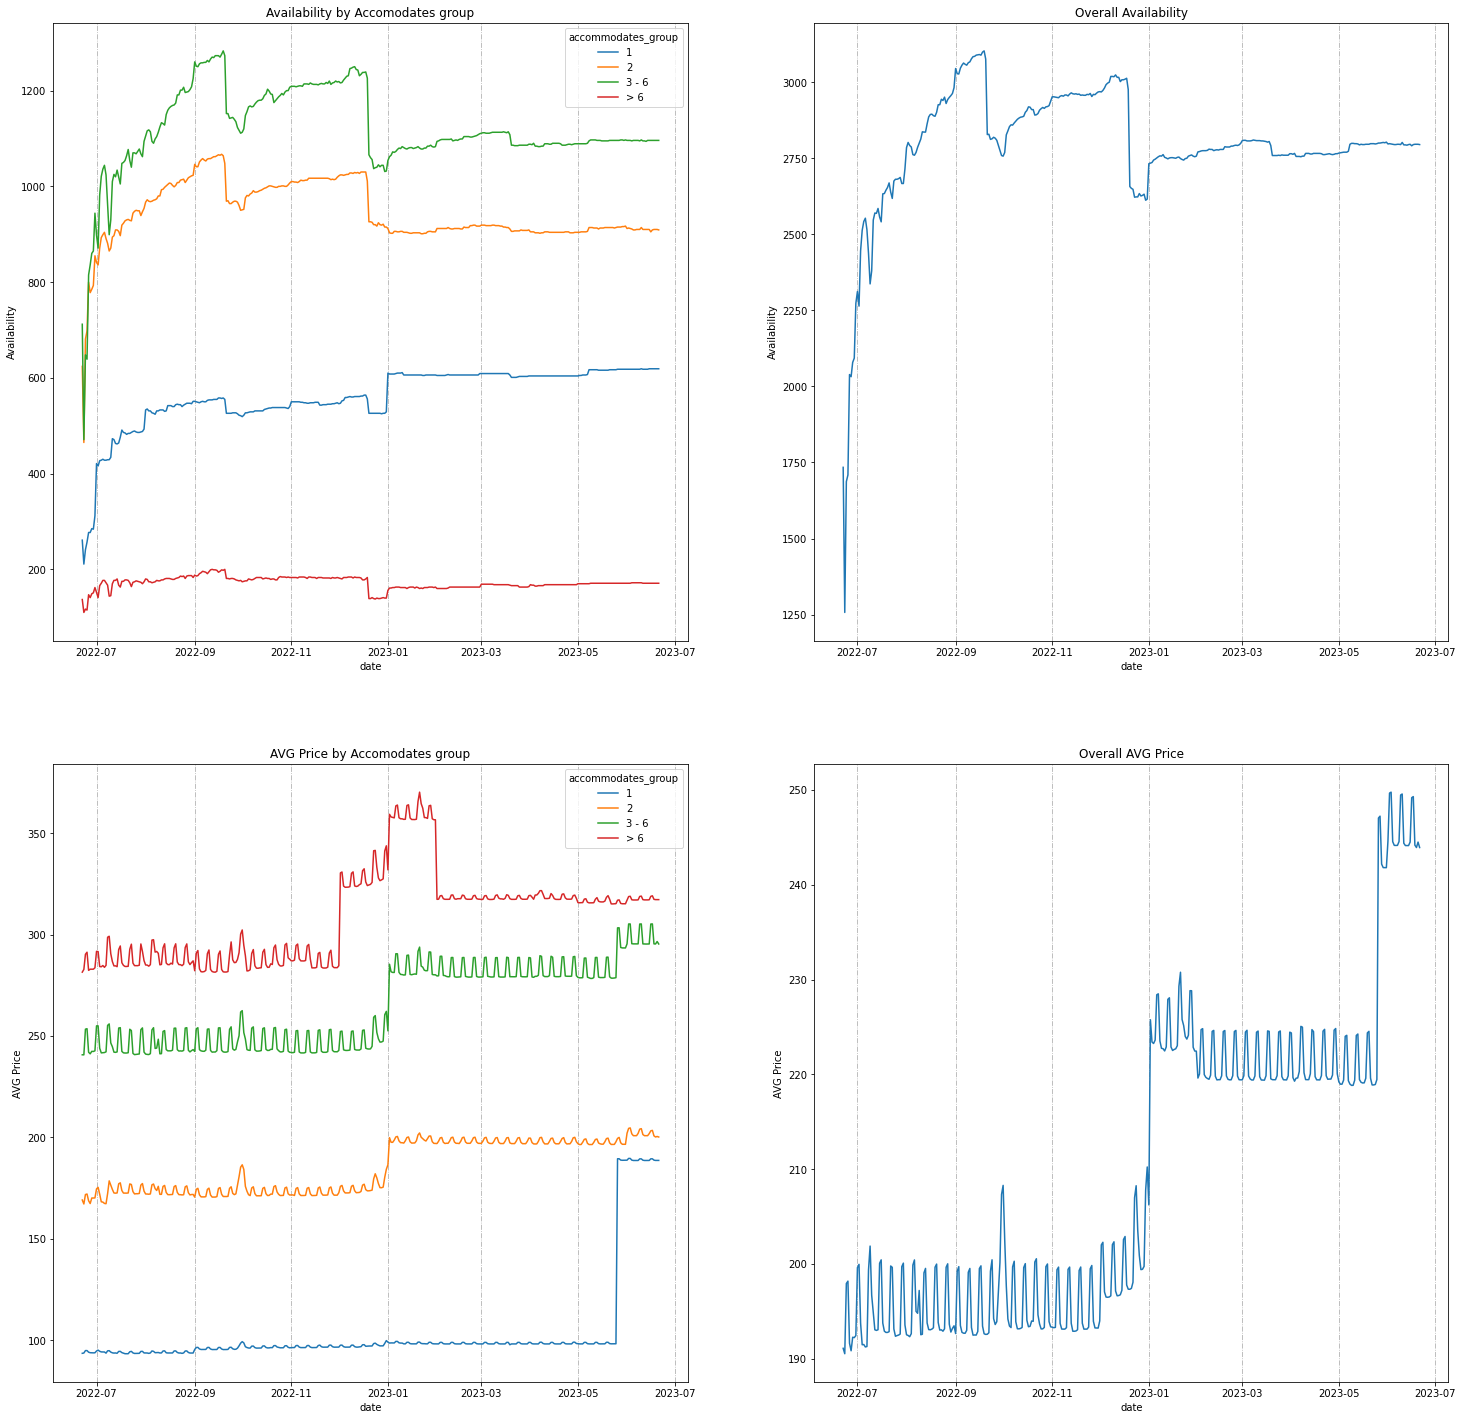

In [6]:
tmp = calendar.copy().set_index('listing_id')

visual_acco_group = tmp.join(listing_type).rename_axis('id').reset_index()
visual_acco_group_sum = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].sum().reset_index()
visual_acco_group_mean = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].mean().reset_index()

plt.figure(figsize=(25, 25))

plt.subplot(221)
sns.lineplot(data=visual_acco_group_sum, x='date', y='available', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('Availability')
plt.title('Availability by Accomodates group')

plt.subplot(222)
sns.lineplot(data=calendar.groupby('date')['available'].sum().reset_index(), x='date', y='available')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('Availability')
plt.title('Overall Availability')

plt.subplot(223)
sns.lineplot(data=visual_acco_group_mean, x='date', y='adjusted_price', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('AVG Price')
plt.title('AVG Price by Accomodates group')

plt.subplot(224)
sns.lineplot(data=calendar.groupby('date')['adjusted_price'].mean().reset_index(), x='date', y='adjusted_price')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('AVG Price')
plt.title('Overall AVG Price')

plt.show()

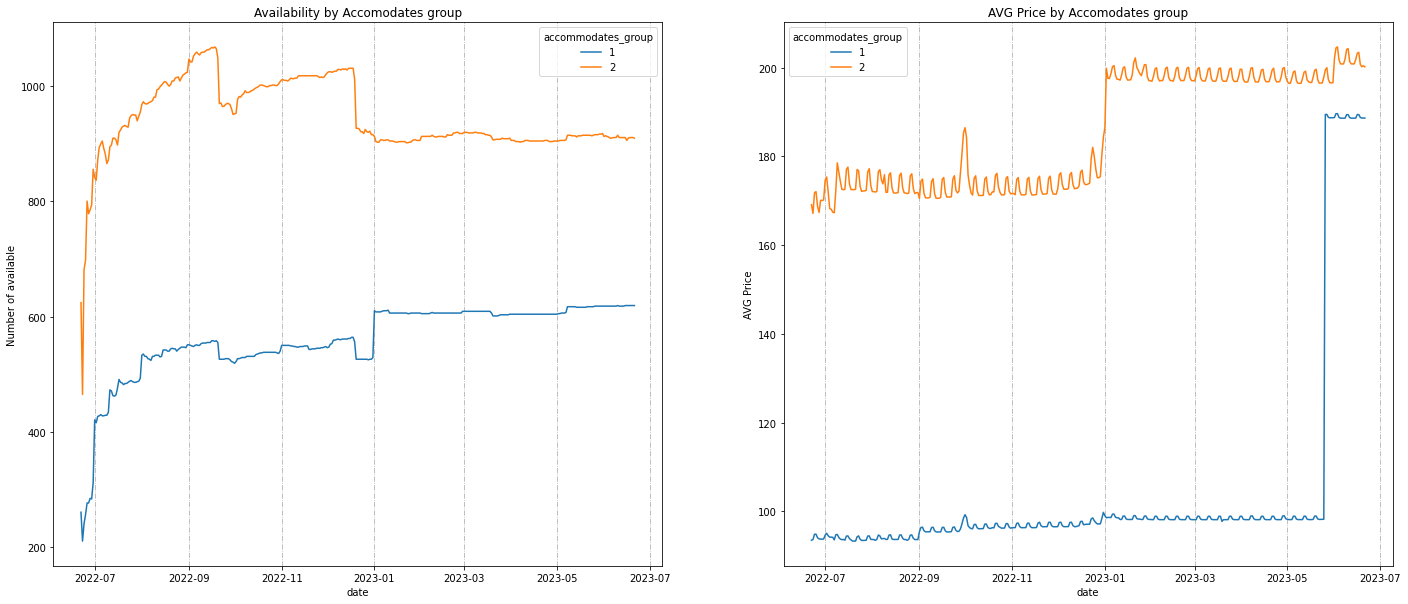

In [7]:
tmp = calendar.copy().set_index('listing_id')

visual_acco_group = tmp.join(listing_type).rename_axis('id').reset_index()
visual_acco_group_sum = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].sum().reset_index()
visual_acco_group_mean = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].mean().reset_index()

visual_acco_group_sum = visual_acco_group_sum[visual_acco_group_sum['accommodates_group'].isin(['1', '2'])]
visual_acco_group_mean = visual_acco_group_mean[visual_acco_group_mean['accommodates_group'].isin(['1', '2'])]


plt.figure(figsize=(24, 10))
plt.subplot(121)
sns.lineplot(data=visual_acco_group_sum, x='date', y='available', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('Number of available')
plt.title('Availability by Accomodates group')


tmp = calendar.copy().set_index('listing_id')

visual_acco_group = tmp.join(listing_type).rename_axis('id').reset_index()
visual_acco_group_mean = visual_acco_group.groupby(['date', 'accommodates_group'])[['available', 'adjusted_price']].mean().reset_index()
visual_acco_group_mean = visual_acco_group_mean[visual_acco_group_mean['accommodates_group'].isin(['1', '2'])]

plt.subplot(122)
sns.lineplot(data=visual_acco_group_mean, x='date', y='adjusted_price', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.ylabel('AVG Price')
plt.title('AVG Price by Accomodates group')

# plt.subplot(212)
# sns.lineplot(data=visual_acco_group_mean, x='date', y='adjusted_price', hue='accommodates_group')
# plt.grid(axis='x', linestyle='-.')
# plt.ylabel('AVG Price')
# plt.title('AVG Price by Accomodates group')

plt.show()

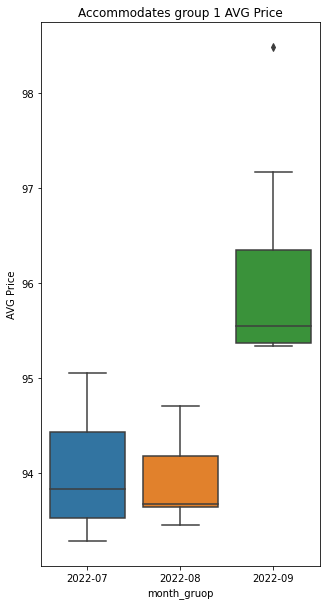

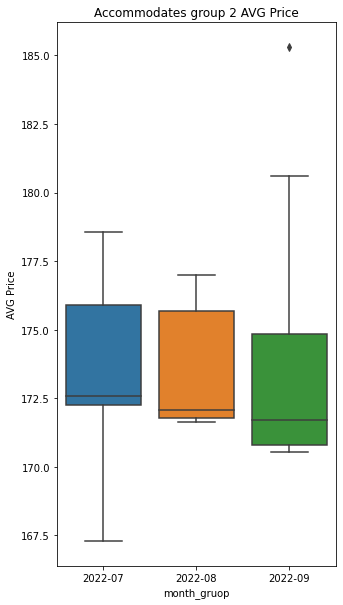

In [47]:
visual_acco_group_mean['month_gruop'] = visual_acco_group_mean['date'].dt.strftime('%Y-%m')
visual_boxplot = visual_acco_group_mean[visual_acco_group_mean['month_gruop'].isin(['2022-07', '2022-08', '2022-09'])]

plt.figure(figsize=[5, 10])
sns.boxplot(data=visual_boxplot[visual_boxplot['accommodates_group'] == '1'], x='month_gruop', y='adjusted_price')
plt.ylabel('AVG Price')
plt.title('Accommodates group 1 AVG Price')
plt.show()

plt.figure(figsize=[5, 10])
sns.boxplot(data=visual_boxplot[visual_boxplot['accommodates_group'] == '2'], x='month_gruop', y='adjusted_price')
plt.ylabel('AVG Price')
plt.title('Accommodates group 2 AVG Price')
plt.show()

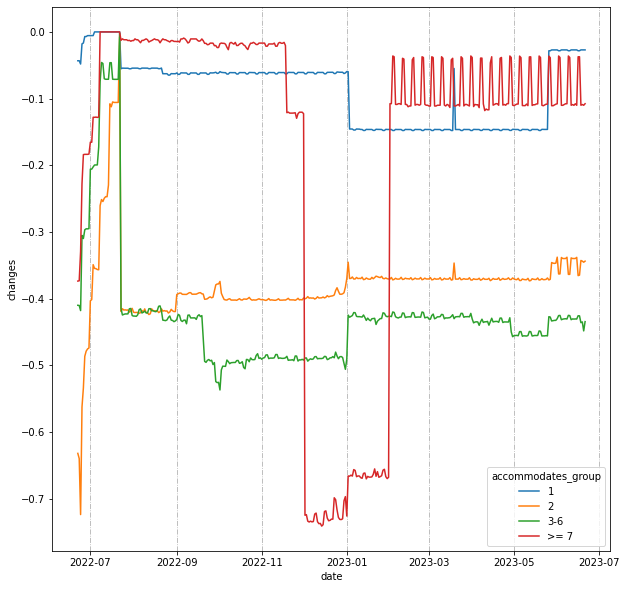

In [47]:
tmp = visual_acco_group#[visual_acco_group['accommodates_group'] == '1']
tmp = tmp.groupby(['accommodates_group', 'date']).mean()
AVG_adjusted_range = ((tmp['adjusted_price'] - tmp['price']) / tmp['price']) *100
AVG_adjusted_range = AVG_adjusted_range.reset_index(name='changes')

plt.figure(figsize=[10, 10])
# sns.boxplot(data=AVG_adjusted_range)
sns.lineplot(data=AVG_adjusted_range, x='date', y='changes', hue='accommodates_group')
plt.grid(axis='x', linestyle='-.')
plt.show()

In [26]:
visual_acco_group

,id,date,available,price,adjusted_price,minimum_nights,maximum_nights,bedrooms,beds,accommodates_group
0,50646,2022-06-22,1,80.0,80.0,92,730,1.0,1.0,2
1,50646,2022-06-23,1,80.0,80.0,92,730,1.0,1.0,2
2,50646,2022-06-24,1,80.0,80.0,92,730,1.0,1.0,2
3,50646,2022-06-25,1,80.0,80.0,92,730,1.0,1.0,2
4,50646,2022-06-26,1,80.0,80.0,92,730,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...
1495747,654142837621609801,2023-06-17,1,193.0,193.0,1,365,1.0,2.0,2
1495748,654142837621609801,2023-06-18,1,193.0,193.0,1,365,1.0,2.0,2
1495749,654142837621609801,2023-06-19,1,193.0,193.0,1,365,1.0,2.0,2
1495750,654142837621609801,2023-06-20,1,193.0,193.0,1,365,1.0,2.0,2


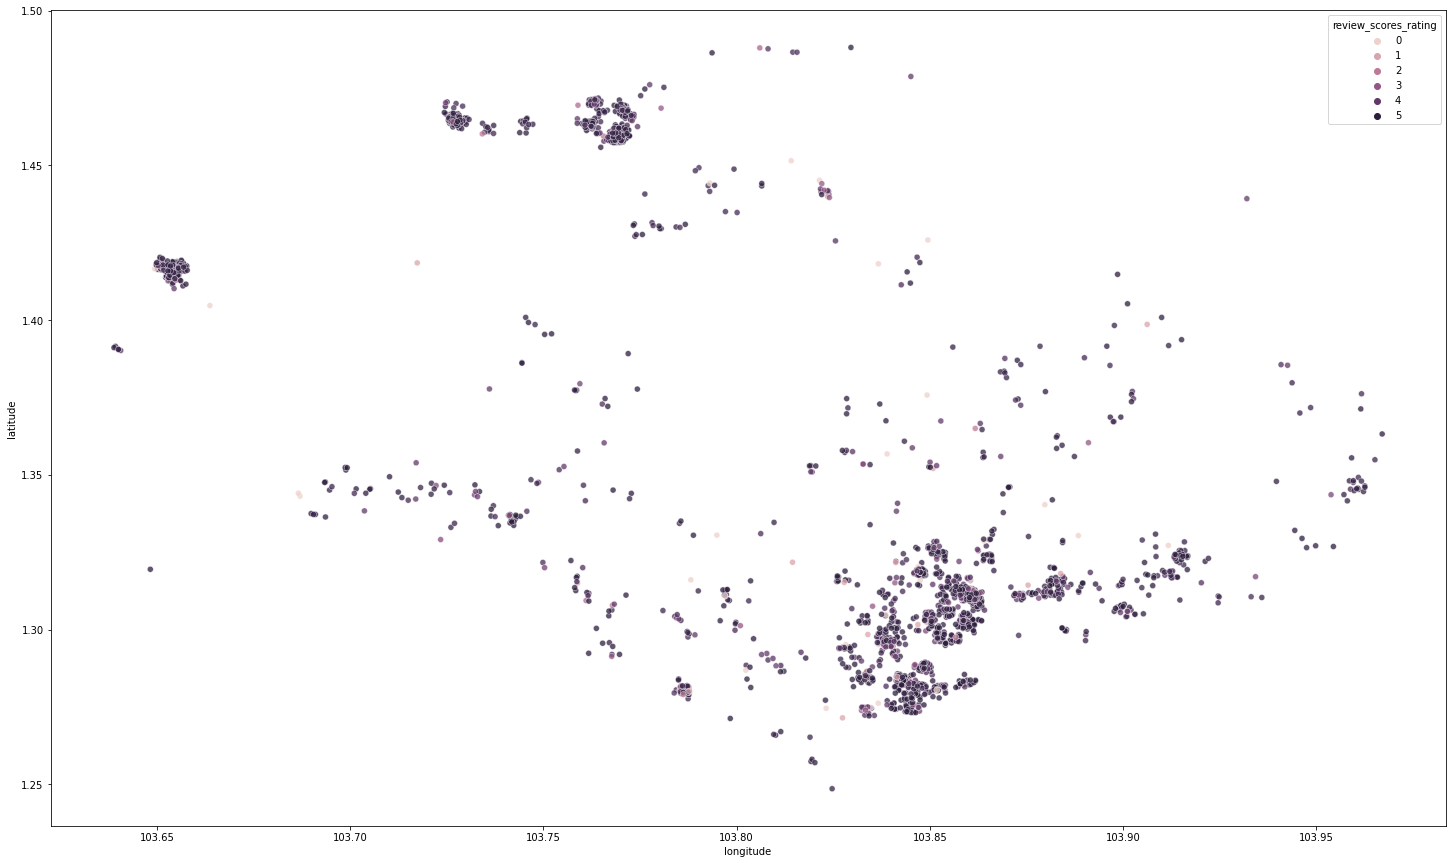

In [8]:
visual_review = listings[['latitude', 'longitude', 'review_scores_rating']].copy()

visual_review['review_scores_rating'] = visual_review['review_scores_rating'].astype('float')

plt.figure(figsize=(25, 15))
sns.scatterplot(data=visual_review, x='longitude', y='latitude', hue='review_scores_rating', alpha=0.75)
plt.show()